<a href="https://colab.research.google.com/github/Rafi076/RTFER/blob/main/ResNet18_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Setup
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as TF
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import random

In [7]:
# Step 2: Unzip the FER-2013 dataset
zip_path = "/content/FER-2013.zip"  # Update if path differs
extract_path = "/content/FER-2013"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("FER-2013 dataset extracted.")

FER-2013 dataset extracted.


In [8]:
# TRAINING Dataset with CLAHE + Augmentations
class FERPreprocessTrainDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = []
        self.labels = []
        self.class_map = sorted(os.listdir(image_dir))

        for label, class_name in enumerate(self.class_map):
            class_folder = os.path.join(image_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)

        # Train-time augmentations
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
            transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Step 1: Grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Step 2: CLAHE instead of basic hist equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Step 3: Convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Step 4: Apply transformations
        img = Image.fromarray(img)
        img = self.augment(img)

        return img, label


# TESTING Dataset with TenCrop Support
class FERPreprocessTestDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = []
        self.labels = []
        self.class_map = sorted(os.listdir(image_dir))

        for label, class_name in enumerate(self.class_map):
            class_folder = os.path.join(image_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)

        # TenCrop (inference-time)
        self.transform = transforms.Compose([
            transforms.Resize(56),
            transforms.TenCrop(48),  # returns 10 crops
            transforms.Lambda(lambda crops: torch.stack([
                transforms.Normalize([0.5]*3, [0.5]*3)(transforms.ToTensor()(crop))
                for crop in crops
            ]))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Grayscale → CLAHE → RGB
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(img)

        # Apply TenCrop + Normalize
        img = self.transform(img)  # shape: [10, 3, 48, 48]
        return img, label

In [9]:
# Define dataset paths
train_path = "/content/FER-2013/FER-2013/train"
test_path = "/content/FER-2013/FER-2013/test"

# Load Datasets
train_dataset = FERPreprocessTrainDataset(train_path)
test_dataset = FERPreprocessTestDataset(test_path)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)  # batch_size = 16 → 10 crops per image


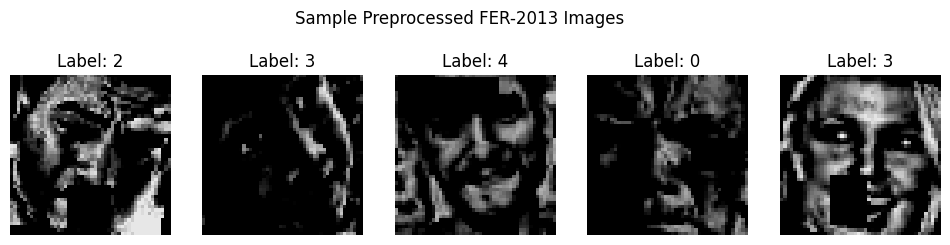

In [10]:
# Step 5: Visualize a few samples
import random
plt.figure(figsize=(12, 3))
for i in range(5):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample Preprocessed FER-2013 Images")
plt.show()

In [11]:
# Step 6: Build the most optimized ResNet18 model for FER-2013
import torch.nn as nn
import torchvision.models as models
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 from torchvision
base_resnet = models.resnet18(pretrained=True)

# Define custom ResNet18-based model
class BestFERResNet18(nn.Module):
    def __init__(self, base_model):
        super(BestFERResNet18, self).__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.fc_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 7)  # FER-2013 has 7 emotion classes
        )
        self._init_weights()

        # 🔒 Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False

    def _init_weights(self):
        for m in self.fc_head:
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.backbone(x)  # [B, 512, 1, 1]
        x = self.fc_head(x)   # [B, 7]
        return x

# Initialize model
model = BestFERResNet18(base_resnet).to(device)

print("Best ResNet18 model is ready on", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


Best ResNet18 model is ready on cuda


In [12]:
# Step 7: Training Setup with all optimizations
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = nn.LogSoftmax(dim=-1)(pred)
        true_dist = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), self.confidence)
        true_dist += self.smoothing / pred.size(1)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-12-196615464.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [14]:
# Step 8 & 9: Advanced Training Loop with AMP, Early Stopping, and Model Checkpointing

num_epochs = 40
best_acc = 0.0
patience = 7
trigger = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  #  Mixed precision for speed
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = correct / total
    avg_loss = running_loss / total
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Evaluation Phase (with TenCrop)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            bs, ncrops, c, h, w = images.size()  # [B, 10, 3, 48, 48]
            images = images.view(-1, c, h, w).to(device)  # → [B*10, 3, 48, 48]
            labels = labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)  # [B*10, 7]
            outputs = outputs.view(bs, ncrops, -1).mean(1)  # → [B, 7]
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping & Checkpointing
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_fer_model.pth")
        print("Best model saved with accuracy:", round(best_acc, 4))
        trigger = 0
    else:
        trigger += 1
        print(f" No improvement. Patience counter: {trigger}/{patience}")
        if trigger >= patience:
            print("Early stopping triggered.")
            break






#  STAGE 2: Unfreeze Backbone and Fine-Tune All Layers
for param in model.backbone.parameters():
    param.requires_grad = True

print("🔓Backbone unfrozen. Starting fine-tuning phase...")

# Reset early stopping variables
trigger = 0
patience = 7
num_epochs = 20  # Or more, based on resources

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):  #  updated per warning
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    scheduler.step()
    train_acc = correct / len(train_loader.dataset)
    print(f"📘 [FT] Epoch {epoch+1} | Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            bs, ncrops, c, h, w = images.size()
            images = images.view(-1, c, h, w).to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
            outputs = outputs.view(bs, ncrops, -1).mean(1)
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"[FT] Validation Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_fer_model.pth")
        print(" Best model saved (fine-tuned)!")
        trigger = 0
    else:
        trigger += 1
        print(f" No improvement. Patience counter: {trigger}/{patience}")
        if trigger >= patience:
            print("Early stopping triggered (fine-tuning).")
            break


/tmp/ipython-input-14-1007947154.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  #  Mixed precision for speed


Epoch 1/40 | Train Loss: 1.7379 | Train Acc: 0.3247


/tmp/ipython-input-14-1007947154.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Accuracy: 0.3885
Best model saved with accuracy: 0.3885
Epoch 2/40 | Train Loss: 1.7369 | Train Acc: 0.3270
Validation Accuracy: 0.3945
Best model saved with accuracy: 0.3945
Epoch 3/40 | Train Loss: 1.7415 | Train Acc: 0.3233
Validation Accuracy: 0.3965
Best model saved with accuracy: 0.3965
Epoch 4/40 | Train Loss: 1.7367 | Train Acc: 0.3314
Validation Accuracy: 0.3963
 No improvement. Patience counter: 1/7
Epoch 5/40 | Train Loss: 1.7435 | Train Acc: 0.3244
Validation Accuracy: 0.3828
 No improvement. Patience counter: 2/7
Epoch 6/40 | Train Loss: 1.7468 | Train Acc: 0.3200
Validation Accuracy: 0.3860
 No improvement. Patience counter: 3/7
Epoch 7/40 | Train Loss: 1.7475 | Train Acc: 0.3196
Validation Accuracy: 0.3695
 No improvement. Patience counter: 4/7
Epoch 8/40 | Train Loss: 1.7479 | Train Acc: 0.3220
Validation Accuracy: 0.3991
Best model saved with accuracy: 0.3991
Epoch 9/40 | Train Loss: 1.7459 | Train Acc: 0.3205
Validation Accuracy: 0.3975
 No improvement. Pat

Merge Train + Val Sets (for stronger training)

In [17]:
import os
import shutil

base_path = "/content/FER-2013/FER-2013"  # Make sure this is your actual path
merged_train_path = os.path.join(base_path, "train_val_merged")

# Create merged directory
os.makedirs(merged_train_path, exist_ok=True)

# Copy only from 'train' folder (since 'val' doesn't exist)
train_path = os.path.join(base_path, "train")
for emotion in os.listdir(train_path):
    src = os.path.join(train_path, emotion)
    dst = os.path.join(merged_train_path, emotion)
    os.makedirs(dst, exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(os.path.join(src, file), os.path.join(dst, file))

print("✅ Merged available training data into:", merged_train_path)


✅ Merged available training data into: /content/FER-2013/FER-2013/train_val_merged


In [18]:
# Step 2: Define BestFERResNet34 Model
import torchvision.models as models
import torch.nn as nn
import torch.nn.init as init

resnet34 = models.resnet34(pretrained=True)

class BestFERResNet34(nn.Module):
    def __init__(self, base_model):
        super(BestFERResNet34, self).__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Remove last FC
        self.fc_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 7)
        )
        self._init_weights()
        for param in self.backbone.parameters():
            param.requires_grad = False

    def _init_weights(self):
        for m in self.fc_head:
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc_head(x)
        return x

model = BestFERResNet34(resnet34).to(device)
print("✅ Loaded BestFERResNet34")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 140MB/s]


✅ Loaded BestFERResNet34


Replace ResNet18 with ResNet34 (stronger backbone)

 Manually Split Merged Data into Train and Val Sets

We’ll split train_val_merged into 90% train and 10% val.

In [21]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

merged_dir = "/content/FER-2013/FER-2013/train_val_merged"
train_dir = "/content/FER-2013/FER-2013/train_split"
val_dir = "/content/FER-2013/FER-2013/val_split"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for emotion in os.listdir(merged_dir):
    emotion_path = os.path.join(merged_dir, emotion)
    images = os.listdir(emotion_path)

    train_images, val_images = train_test_split(images, test_size=0.1, random_state=42)

    # Train
    os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(train_dir, emotion, img))

    # Val
    os.makedirs(os.path.join(val_dir, emotion), exist_ok=True)
    for img in val_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(val_dir, emotion, img))

print("Data split complete: 90% train, 10% val")


Data split complete: 90% train, 10% val


Preprocessing + Augmentation + Dataloader Setup (Best Version)

In [22]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

# ImageNet normalization (for pretrained models)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training Transform: Strong augmentation
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),                      # Resize to standard size
    transforms.RandomCrop(44),                        # Slightly smaller crop
    transforms.RandomHorizontalFlip(),                # Horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4), # Color jitter
    transforms.RandomRotation(10),                    # Rotation
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean, std)                   # Normalize
])

#  Test/Validation Transform: TenCrop + Normalize
test_transform = transforms.Compose([
    transforms.Resize(48),
    transforms.TenCrop(44),  # 10 crops from the image
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(mean, std)(
            transforms.ToTensor()(crop)) for crop in crops
    ]))
])


Dataset & DataLoader Setup

In [23]:
#  Dataset paths (ensure they exist)
train_path = "/content/FER-2013/FER-2013/train_split"
val_path = "/content/FER-2013/FER-2013/val_split"
test_path = "/content/FER-2013/FER-2013/test"

#  Load datasets with transformations
train_dataset = ImageFolder(train_path, transform=train_transform)
val_dataset = ImageFolder(val_path, transform=test_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" All dataloaders ready with strong augmentation and TenCrop.")


 All dataloaders ready with strong augmentation and TenCrop.


Best ResNet18 Model Setup

In [24]:
import torch.nn as nn
import torchvision.models as models
import torch

#  Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load pretrained ResNet18 backbone
resnet18 = models.resnet18(pretrained=True)

#  Freeze the backbone initially
for param in resnet18.parameters():
    param.requires_grad = False

#  Define custom head (with BatchNorm + Dropout)
class EmotionResNet18(nn.Module):
    def __init__(self):
        super(EmotionResNet18, self).__init__()
        self.backbone = nn.Sequential(*list(resnet18.children())[:-1])  # remove original FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 7)  # 7 classes in FER-2013
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# Instantiate and move to device
model = EmotionResNet18().to(device)

print(" Model loaded and ready with frozen backbone + custom head.")


 Model loaded and ready with frozen backbone + custom head.


Sample Visualization

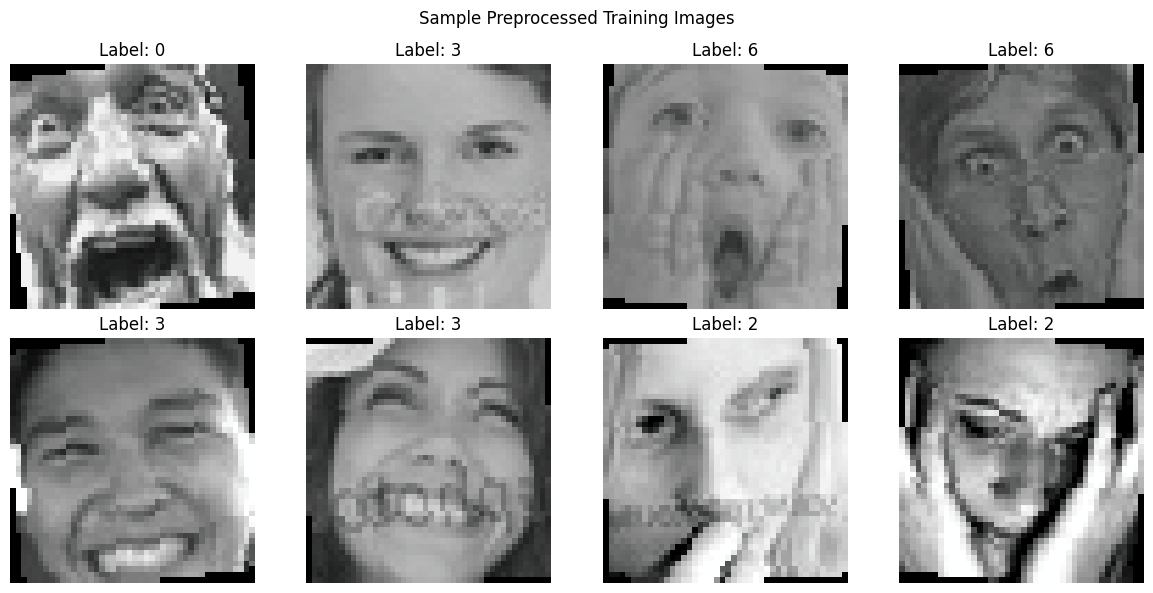

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# For unnormalizing images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

#  Visualize a few training samples
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(12, 6))
for idx in range(8):
    plt.subplot(2, 4, idx + 1)
    imshow(images[idx].cpu(), title=f"Label: {labels[idx].item()}")
plt.suptitle("Sample Preprocessed Training Images")
plt.tight_layout()
plt.show()


Training Setup

In [26]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

#  Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        true_dist += self.smoothing / pred.size(1)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

#  Instantiate Loss
criterion = LabelSmoothingLoss(smoothing=0.1)

#  Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

#  Mixed Precision Scaler
scaler = torch.cuda.amp.GradScaler()

print(" Training setup complete (Label Smoothing + AdamW + Cosine Annealing + AMP)")


 Training setup complete (Label Smoothing + AdamW + Cosine Annealing + AMP)


/tmp/ipython-input-26-427753110.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


 Training Loop with Early Stopping + TenCrop Evaluation

In [27]:
import copy

num_epochs = 40
best_acc = 0.0
patience = 7
trigger = 0

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):  # AMP
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = correct / total
    avg_loss = running_loss / total
    print(f" Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Evaluation with TenCrop
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            bs, ncrops, c, h, w = images.size()
            images = images.view(-1, c, h, w).to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)

            outputs = outputs.view(bs, ncrops, -1).mean(1)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f" Validation Accuracy: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_fer_model_stage1.pth")
        print(" Best model saved!")
        trigger = 0
    else:
        trigger += 1
        print(f" No improvement. Patience counter: {trigger}/{patience}")
        if trigger >= patience:
            print(" Early stopping triggered.")
            break


 Epoch 1/40 | Train Loss: 1.9956 | Train Acc: 0.2502
 Validation Accuracy: 0.3636
 Best model saved!
 Epoch 2/40 | Train Loss: 1.8070 | Train Acc: 0.2913
 Validation Accuracy: 0.3751
 Best model saved!
 Epoch 3/40 | Train Loss: 1.7804 | Train Acc: 0.3014
 Validation Accuracy: 0.3664
 No improvement. Patience counter: 1/7
 Epoch 4/40 | Train Loss: 1.7684 | Train Acc: 0.3107
 Validation Accuracy: 0.3720
 No improvement. Patience counter: 2/7
 Epoch 5/40 | Train Loss: 1.7629 | Train Acc: 0.3164
 Validation Accuracy: 0.3758
 Best model saved!
 Epoch 6/40 | Train Loss: 1.7570 | Train Acc: 0.3158
 Validation Accuracy: 0.3678
 No improvement. Patience counter: 1/7
 Epoch 7/40 | Train Loss: 1.7561 | Train Acc: 0.3135
 Validation Accuracy: 0.3615
 No improvement. Patience counter: 2/7
 Epoch 8/40 | Train Loss: 1.7482 | Train Acc: 0.3205
 Validation Accuracy: 0.3803
 Best model saved!
 Epoch 9/40 | Train Loss: 1.7449 | Train Acc: 0.3210
 Validation Accuracy: 0.3786
 No improvement. Patience coun

 Fine-Tuning Code

In [28]:
#  Unfreeze backbone
for param in model.backbone.parameters():
    param.requires_grad = True

print("Backbone unfrozen. Starting fine-tuning phase...")

# Reset early stopping variables
trigger = 0
patience = 7
num_epochs = 20
best_ft_acc = best_acc  # continue tracking from previous best

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = correct / total
    avg_loss = running_loss / total
    print(f" [FT] Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            bs, ncrops, c, h, w = images.size()
            images = images.view(-1, c, h, w).to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)

            outputs = outputs.view(bs, ncrops, -1).mean(1)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f" [FT] Validation Accuracy: {val_acc:.4f}")

    # Early Stopping & Save
    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        torch.save(model.state_dict(), "best_fer_model_finetuned.pth")
        print(" Best fine-tuned model saved!")
        trigger = 0
    else:
        trigger += 1
        print(f" No improvement. Patience counter: {trigger}/{patience}")
        if trigger >= patience:
            print(" Early stopping triggered (fine-tune).")
            break


Backbone unfrozen. Starting fine-tuning phase...
 [FT] Epoch 1/20 | Train Loss: 1.5406 | Train Acc: 0.4523
 [FT] Validation Accuracy: 0.5456
 Best fine-tuned model saved!
 [FT] Epoch 2/20 | Train Loss: 1.4307 | Train Acc: 0.5123
 [FT] Validation Accuracy: 0.5595
 Best fine-tuned model saved!
 [FT] Epoch 3/20 | Train Loss: 1.3833 | Train Acc: 0.5413
 [FT] Validation Accuracy: 0.5859
 Best fine-tuned model saved!
 [FT] Epoch 4/20 | Train Loss: 1.3526 | Train Acc: 0.5555
 [FT] Validation Accuracy: 0.5950
 Best fine-tuned model saved!
 [FT] Epoch 5/20 | Train Loss: 1.3255 | Train Acc: 0.5737
 [FT] Validation Accuracy: 0.5936
 No improvement. Patience counter: 1/7
 [FT] Epoch 6/20 | Train Loss: 1.3095 | Train Acc: 0.5786
 [FT] Validation Accuracy: 0.6086
 Best fine-tuned model saved!
 [FT] Epoch 7/20 | Train Loss: 1.2874 | Train Acc: 0.5915
 [FT] Validation Accuracy: 0.6319
 Best fine-tuned model saved!
 [FT] Epoch 8/20 | Train Loss: 1.2673 | Train Acc: 0.6016
 [FT] Validation Accuracy: 0.6